<h1>Самоорганизующиеся карты сеть Кохонена </h1>


<span>В сетях Кохонена используется обучение без учителя. Для обучения сети применяются механизмы конкуренции. При подаче на вход сети вектора х побеждает тот нейрон, вектор весов которого в наименьшей степени отличаются от входного вектора. </span>

<h4>Загружаем и читаем данные</h4>

In [7]:
import numpy as np    # linear algebra
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from sklearn.preprocessing import MinMaxScaler #для нормализации

import os
import random


patterns = []
classes = []

#читаем дата сет
filename = 'Iris_data.txt'
file = open(filename,'r')

for line in file.readlines():
    row = line.strip().split(',')
    patterns.append(row[0:4])
    classes.append(row[4])
    
print("Iris Data Загружены")

file.close

patterns = np.asarray(patterns,dtype=np.float32)
#print(patterns)

sample_no = np.random.randint(0,len(patterns))

print("Образец шаблона: " + str(patterns[int(sample_no)]))
print("Класс вышеупомянутого шаблона: " + str(classes[int(sample_no)]))


#Нормализация набора данных
feature_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = feature_scaler.fit_transform(patterns)
df_scaled = pd.DataFrame(data=df_scaled)
df_scaled.head()

Iris Data Загружены
Образец шаблона: [7.6 3.  6.6 2.1]
Класс вышеупомянутого шаблона: Iris-virginica


,0,1,2,3
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


<h4>Определяем параметры для сети SOM</h4>

In [8]:
som_width = 8
som_length = 8
epochs = 10000
initial_learning_rate =0.01
np.random.seed(10)

In [9]:
raws,cols = df_scaled.shape
print("Необработанный набор данных состоит из count=%d записей и column count=%d" %(raws, cols))

Необработанный набор данных состоит из count=150 записей и column count=4


In [10]:
initial_radius = max(som_width, som_length)/2
time_constant = epochs/np.log(initial_radius)

In [11]:
som_net = np.random.random((som_width, som_length, cols))
print("Начальные веса, установленные для сети SOM:")
print(som_net)

Начальные веса, установленные для сети SOM:
[[[0.77132064 0.02075195 0.63364823 0.74880388]
  [0.49850701 0.22479665 0.19806286 0.76053071]
  [0.16911084 0.08833981 0.68535982 0.95339335]
  [0.00394827 0.51219226 0.81262096 0.61252607]
  [0.72175532 0.29187607 0.91777412 0.71457578]
  [0.54254437 0.14217005 0.37334076 0.67413362]
  [0.44183317 0.43401399 0.61776698 0.51313824]
  [0.65039718 0.60103895 0.8052232  0.52164715]]

 [[0.90864888 0.31923609 0.09045935 0.30070006]
  [0.11398436 0.82868133 0.04689632 0.62628715]
  [0.54758616 0.819287   0.19894754 0.8568503 ]
  [0.35165264 0.75464769 0.29596171 0.88393648]
  [0.32551164 0.1650159  0.39252924 0.09346037]
  [0.82110566 0.15115202 0.38411445 0.94426071]
  [0.98762547 0.45630455 0.82612284 0.25137413]
  [0.59737165 0.90283176 0.53455795 0.59020136]]

 [[0.03928177 0.35718176 0.07961309 0.30545992]
  [0.33071931 0.7738303  0.03995921 0.42949218]
  [0.31492687 0.63649114 0.34634715 0.04309736]
  [0.87991517 0.76324059 0.87809664 0.41

Определяем основные функции, которые необходимы для скорости обучения, радиуса и расчёта евклидова расстояния

In [12]:
def update_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def update_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_euclidian_dis(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

<h4>Вычисляем наилучшее соответствие</h4> 
<span>Best Matching Unit (BMU)<span><br>
<span>Находим победителя<span>

In [13]:
def find_best_mathcing_Unit(data_point):
    bmu_pos = np.array ([0, 0])
    min_dist = np.iinfo(np.int32).max
    input_dim = len(data_point)
    
    for x in range(som_width):
        for y in range(som_length):
            som_weight_vector = som_net[x, y, :].reshape(1, 4)
            
            euclidian_dist = calculate_euclidian_dis(som_weight_vector, data_point)#евклидово расстояние
            
            if euclidian_dist < min_dist:
                min_dist = euclidian_dist
                bmu_pos = np.array([x, y])
                
                
    bmu = som_net[bmu_pos[0], bmu_pos[1], :].reshape(1, 4)
    
    return (bmu, bmu_pos)

<span>Функция соседства для вычисления влияния у победителя и выбранного узла</span>

In [14]:
def neighbourhood_function(bmu_location, selected_node_location, radius):
    euclidian_dist_to_bmu = calculate_euclidian_dis(bmu_location, selected_node_location)
    return np.exp(-euclidian_dist_to_bmu / (2* (radius**2)))

<span>Обучение сети SOM с помощью набора данных Iris</span>

In [15]:
df_scaled = df_scaled.sample(frac=1)

rad_values = list()
learn_rates_values = list()
rad_values.append(initial_radius)  #добавляем в конец списка
learn_rates_values.append(initial_learning_rate)

for i in range(epochs):
    data_point = np.array(df_scaled.sample())
    bmu, bmu_idx = find_best_mathcing_Unit(data_point) #ф для нахождения победителя

    r_new = update_radius(initial_radius, i, time_constant)
    new_learning_rate = update_learning_rate(initial_learning_rate, i, epochs)
    
    rad_values.append(r_new)
    learn_rates_values.append(new_learning_rate)
    
    for x in range(som_width):
        for y in range(som_length):
            w = som_net[x, y, :].reshape(1, 4)
            w_dist = calculate_euclidian_dis(np.array([x, y]), bmu_idx)
            
            if w_dist <= r_new:
                influence = neighbourhood_function(bmu, w, r_new)
                new_w = w + (new_learning_rate * influence * (data_point - w))
                som_net[x, y, :] = new_w.reshape(1, 4)     

Text(0.5, 1.0, 'Значение радиуса')

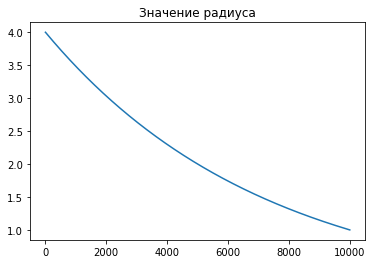

In [19]:
from matplotlib import pyplot as plt
plt.plot(rad_values)
plt.title('Значение радиуса')

Text(0.5, 1.0, 'Значение скорости обучения')

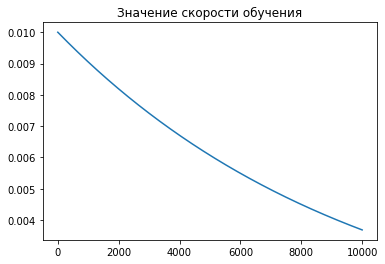

In [18]:
plt.plot(learn_rates_values)
plt.title('Значение скорости обучения')

<h3> Визуализация весов SOM после нескольких эпох</h3>

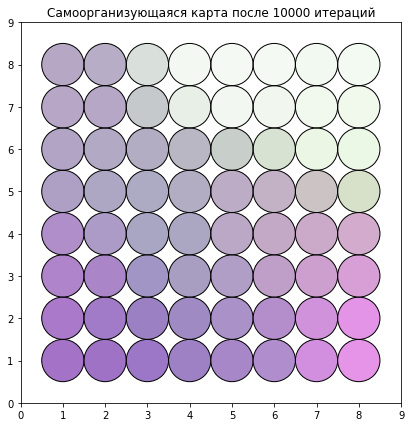

In [20]:
from matplotlib import patches as patches

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1, aspect='equal')
ax.set_xlim((0, som_width+1))
ax.set_ylim((0, som_length+1))
ax.set_title('Самоорганизующаяся карта после %d итераций' % epochs)

for x in range(1, som_width + 1):
    for y in range(1, som_length + 1):
        ax.add_patch(patches.Circle((x, y), 0.5, facecolor=som_net[x-1,y-1,:], edgecolor='black'))
plt.show()

fig.savefig('SOM_iris_data.png')

<span>Из приведенного выше графика видна кластеризация данных:</span> <br>
<span>одинаковые цвета в соседстве -это один кластер и разные кластеры с разными цветами</span>

<h4>Вычисление u matrix на основе вышеприведенной решетки SOM</h4>

----------------------------------------------------------------------------------------------------
соседние координаты для x=1, y=1
0 0
0 1
0 2
1 0
1 2
2 0
2 1
2 2
Сумма расстояний до соседних весов=0.690071, средняя величина=0.086259
----------------------------------------------------------------------------------------------------
соседние координаты для x=1, y=2
0 1
0 2
0 3
1 1
1 3
2 1
2 2
2 3
Сумма расстояний до соседних весов=0.912491, средняя величина=0.114061
----------------------------------------------------------------------------------------------------
соседние координаты для x=1, y=3
0 2
0 3
0 4
1 2
1 4
2 2
2 3
2 4
Сумма расстояний до соседних весов=0.931236, средняя величина=0.116405
----------------------------------------------------------------------------------------------------
соседние координаты для x=1, y=4
0 3
0 4
0 5
1 3
1 5
2 3
2 4
2 5
Сумма расстояний до соседних весов=0.730355, средняя величина=0.091294
----------------------------------------------------

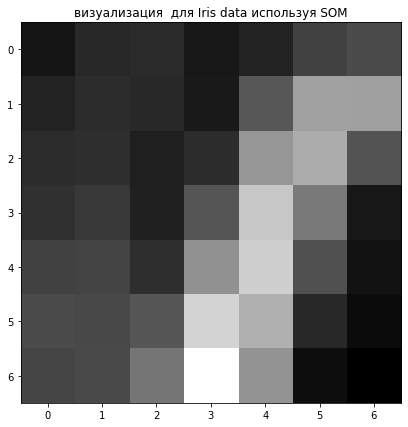

In [21]:
import numpy as np 
u_matrix = np.zeros((som_width-1, som_length-1))

for x in range(1, som_width):
    for y in range(1, som_length):
        neighbour_list = list()
        print("-"* 100)
        print("соседние координаты для x=%d, y=%d" %(x,y))
        for u in range(x-1, x+2):
            if (u < 0 or u > (som_width-1)):
                continue
            for v in range(y-1, y+2):
                if(v < 0 or v > (som_length-1)):
                    continue
                if (u == x and v == y):
                    continue
                neighbour_list.append(np.array([u,v]))
                print(u,v)
        sum=0
        for idx in neighbour_list:
            sum += calculate_euclidian_dis(som_net[x,y,:], som_net[idx[0],idx[1],:])
        
        avg = sum/len(neighbour_list)
        print("Сумма расстояний до соседних весов=%f, средняя величина=%f" % (sum, avg))     
        u_matrix[x-1,y-1] = avg
      
    
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(7,7))
plt.title("визуализация  для Iris data используя SOM")
plt.imshow(u_matrix, cmap="gray")
plt.show()
fig.savefig('U_Matrix_iris.png')

----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=1
0 0
0 1
0 2
1 0
1 2
2 0
2 1
2 2
Sum of distance to neighbour weights=0.690071, average=0.086259
----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=2
0 1
0 2
0 3
1 1
1 3
2 1
2 2
2 3
Sum of distance to neighbour weights=0.912491, average=0.114061
----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=3
0 2
0 3
0 4
1 2
1 4
2 2
2 3
2 4
Sum of distance to neighbour weights=0.931236, average=0.116405
----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=4
0 3
0 4
0 5
1 3
1 5
2 3
2 4
2 5
Sum of distance to neighbour weights=0.730355, average=0.091294
--------------------------------------------------------------------------------

<h3>Визуализация</h3>

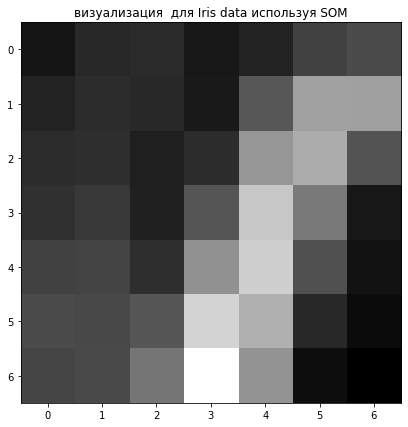

In [23]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(7,7))
plt.title("визуализация  для Iris data используя SOM")
plt.imshow(u_matrix, cmap="gray")
plt.show()
fig.savefig('U_Matrix_iris.png')

<span>На полученном изображении в градациях серого можно увидеть - светлые цвета отображают близко расположенные векторы узлов, а темные цвета - более удаленные друг от друга векторы узлов. Поэтому группы светлых цветов можно рассматривать как кластеры, а темные части - как границы между кластерами.</span>

U-матрица — это визуальное представление расстояний между нейронами в пространстве входных измерений данных. А именно  вычисляете расстояние между соседними нейронами, используя их обученный вектор. Если ваша входная размерность была равна 4, то каждый нейрон на обученной карте также соответствует 4-мерному вектору. Допустим, у вас есть шестиугольная карта 3x3.
Элементы {x,y} — это расстояние между нейронами x и y, а значения в элементах {x} — это среднее значение окружающих значений. Например, {4,5} = расстояние(4,5) и {4} = среднее({1,4}, {2,4}, {4,5}, {4,7}). Для расчета расстояния вы используете обученный 4-мерный вектор каждого нейрона и формулу расстояния, которую вы использовали для тренировки карты (обычно евклидово расстояние). Таким образом, значения U-матрицы являются только числами (а не векторами). Затем можно присвоить светло-серый цвет наибольшему из этих значений, темно-серый — наименьшему, а остальные значения — соответствующим оттенкам серого. Вы можете использовать эти цвета для рисования клеток U-матрицы и иметь визуализированное представление расстояний между нейронами.